In [1]:
import cv2 
from openvino.inference_engine import IECore, StatusCode
import numpy as np

import matplotlib.pyplot as plt
import glob
import time
from tqdm.notebook import tqdm

## Read In Images

In [2]:
image_paths = glob.glob('data/images/*.jpg')
image_paths

['data/images\\baseballs.jpg', 'data/images\\sloth.jpg']

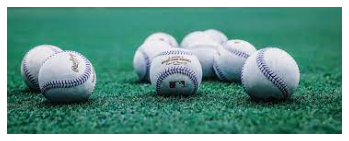

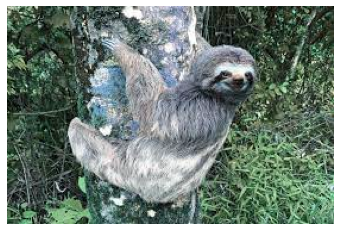

In [3]:
for path in image_paths:
    img = cv2.imread(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 

## OpenVINO Inference

In [4]:
# Get SqueezeNet Labels
# https://github.com/runwayml/model-squeezenet/blob/master/labels.json
with open('data/sqNet_labels.txt','r') as f:
    labels_map = f.read()
    labels = eval(labels_map)
labels

{'0': 'tench, Tinca tinca',
 '1': 'goldfish, Carassius auratus',
 '2': 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 '3': 'tiger shark, Galeocerdo cuvieri',
 '4': 'hammerhead, hammerhead shark',
 '5': 'electric ray, crampfish, numbfish, torpedo',
 '6': 'stingray',
 '7': 'cock',
 '8': 'hen',
 '9': 'ostrich, Struthio camelus',
 '10': 'brambling, Fringilla montifringilla',
 '11': 'goldfinch, Carduelis carduelis',
 '12': 'house finch, linnet, Carpodacus mexicanus',
 '13': 'junco, snowbird',
 '14': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 '15': 'robin, American robin, Turdus migratorius',
 '16': 'bulbul',
 '17': 'jay',
 '18': 'magpie',
 '19': 'chickadee',
 '20': 'water ouzel, dipper',
 '21': 'kite',
 '22': 'bald eagle, American eagle, Haliaeetus leucocephalus',
 '23': 'vulture',
 '24': 'great grey owl, great gray owl, Strix nebulosa',
 '25': 'European fire salamander, Salamandra salamandra',
 '26': 'common newt, Triturus vulga

### Prepare Models and Configuration

###### Download model and Convert to XML + BIN representation
1. python [path_to_model_downloader]/downloader.py --name squeezenet1.1 -o [output_directory]
2. python [path_to_model_converter]/converter.py -d [model_direcotry] --name [model_name] -o [output_directory] <br>
<b>Note: You need to run these python files in administrator mode otherwise you will get [Permission Denied Error]</b>

In [5]:
# Model Path
model_xml = "intel_models/squeezenet1.1.xml"
model_bin = "intel_models/squeezenet1.1.bin"

"""
After a few tests, setting device to GPU does not necessarily improve FPS
"""
# Device
device = 'CPU' # Options include CPU, GPU, MYRIAD, [HDDL or HETERO] I am not familiar with the last two

###### Prepare Network

In [6]:
def PrepareNetWork(model_xml,model_bin,device):
    ie = IECore()
    net = ie.read_network(model = model_xml,weights = model_bin)

    ####################### Very Important #############################################
    # Check to make sure that the plugin has support for all layers in the model
    supported_layers = ie.query_network(net,device_name = device)
    unsupported_layers = [layer for layer in supported_layers.values() if layer!= device]
    if len(unsupported_layers)>0:
        raise Exception(f"Number of unsupported layers {len(unsupported_layers)}")
    ####################################################################################
    

    exec_net = ie.load_network(network=net, device_name = device)

    # Store name of input and output blobs
    input_blob = next(iter(net.input_info))
    output_blob = next(iter(net.outputs))

    # Extract Dimension (n:batch, c:color channel,h: height, w: width )
    n, c ,h ,w = net.input_info[input_blob].input_data.shape
    print('Extract Model Input Dimension:',n,c,h,w)
    
    return (input_blob,output_blob), exec_net, (n,c,h,w)

In [7]:
# Prepare Network
inputs_outputs, execution_network, dimensions = PrepareNetWork(model_xml,model_bin,device)

# Extract Required Input dimension
n,c,h,w = dimensions

# Extract input and output names
input_blob, output_blob = inputs_outputs

# Print Networf Information
print(f"Input_name: {input_blob:>6}\nOutput_name: {output_blob:>5}")
print(f"OpenVINO Engine: {execution_network}")

Extract Model Input Dimension: 1 3 227 227
Input_name:   data
Output_name:  prob
OpenVINO Engine: <openvino.inference_engine.ie_api.ExecutableNetwork object at 0x0000020F7C9889F0>


###### Prepare Input

In [8]:
def PrepareInputImage(input_path,n,c,h,w):
    
    # height width channels
    image = cv2.imread(input_path)
    
    # Resize
    in_frame = cv2.resize(image,(w,h))
    in_frame = in_frame.transpose((2,0,1)) # Moving color channels to head
    in_frame = in_frame.reshape((n,c,h,w))
    return image, in_frame

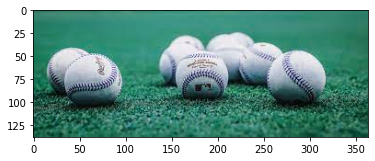

In [9]:
original_image, inference_frame = PrepareInputImage(image_paths[0],n,c,h,w)
plt.imshow(original_image)

In [10]:
def MakePrediction(execution_network, input_blob, inference_frame):
    st_time = time.time()
    # Run Inference
    result = execution_network.infer(inputs = {input_blob:inference_frame})
    
    ed_time = time.time()
    
    
    time_sp = ed_time-st_time
    FPS = np.round((1/time_sp),4)
    print(f"FPS: {FPS}\n")
    
    return FPS,result

In [11]:
FPS, result = MakePrediction(execution_network,input_blob,inference_frame)

FPS: 327.6288



#### Map to Labels

In [12]:
#### Extract Output
class_proba = np.squeeze(result[output_blob])

# Get Top 10 Predictions
# argsort is asecnding order, thus the last ten items have the greatest value
# [::-1] reverse the order to get top 10
top_idx = np.argsort(class_proba)[-10:][::-1]

for idx in top_idx:
    if class_proba[idx] <= proba_threshold:
        pass
    else:
        pred = labels[str(idx)]
        print("Prediction: ",np.round((class_proba[idx]*100),2),"%",pred) 

Prediction:  58.09 % golf ball
Prediction:  41.88 % baseball


##### Uhm.... Reasonable Prediction? Let's check what the model sees

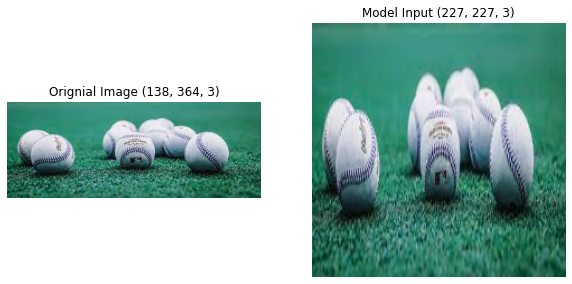

In [13]:
# height width channels
image = cv2.imread(image_paths[0])
# Resize
in_frame = cv2.resize(image,(w,h))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title(f"Orignial Image {image.shape}")
plt.imshow(original_image)
plt.axis('off')


plt.subplot(1,2,2)
plt.title(f"Model Input {in_frame.shape}")
plt.imshow(in_frame)
plt.axis('off')

plt.show()

## 

## Let's Try Sloth

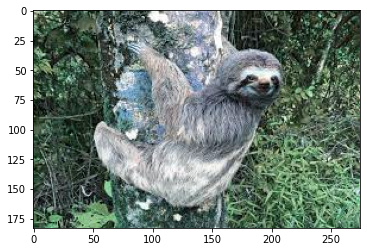

In [14]:
original_image, inference_frame = PrepareInputImage(image_paths[1],n,c,h,w)
plt.imshow(original_image)

In [15]:
proba_threshold = 0.4
FPS, result = MakePrediction(execution_network,input_blob,inference_frame,proba_threshold)

FPS: 321.1073



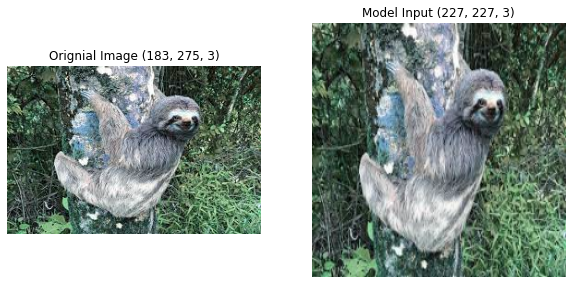

In [16]:
# height width channels
image = cv2.imread(image_paths[1])
# Resize
in_frame = cv2.resize(image,(w,h))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title(f"Orignial Image {image.shape}")
plt.imshow(original_image)
plt.axis('off')


plt.subplot(1,2,2)
plt.title(f"Model Input {in_frame.shape}")
plt.imshow(in_frame)
plt.axis('off')

plt.show()

In [17]:
#### Extract Output
class_proba = np.squeeze(result[output_blob])

# Get Top 10 Predictions
# argsort is asecnding order, thus the last ten items have the greatest value
# [::-1] reverse the order to get top 10
top_idx = np.argsort(class_proba)[-10:][::-1]

for idx in top_idx:
    if class_proba[idx] <= proba_threshold:
        pass
    else:
        pred = labels[str(idx)]
        print("Prediction: ",np.round((class_proba[idx]*100),2),"%",pred) 

Prediction:  99.97 % three-toed sloth, ai, Bradypus tridactylus


## 

## Make continuous Inference

###### Prepare Network

In [18]:
# Model Path
model_xml = "intel_models/squeezenet1.1.xml"
model_bin = "intel_models/squeezenet1.1.bin"

"""
After a few tests, setting device to GPU does not necessarily improve FPS
"""
# Device
device = 'GPU' # Options include CPU, GPU, MYRIAD, [HDDL or HETERO] I am not familiar with the last two
# device = 'GPU'

# Prepare Network
inputs_outputs, execution_network, dimensions = PrepareNetWork(model_xml,model_bin,device)

# Extract Required Input dimension
n,c,h,w = dimensions

# Extract input and output names
input_blob, output_blob = inputs_outputs

# Print Networf Information
print(f"Input_name: {input_blob:>6}\nOutput_name: {output_blob:>5}")
print(f"OpenVINO Engine: {execution_network}")

Extract Model Input Dimension: 1 3 227 227
Input_name:   data
Output_name:  prob
OpenVINO Engine: <openvino.inference_engine.ie_api.ExecutableNetwork object at 0x0000020F7C681A90>


In [19]:
image_paths = glob.glob('data/images/cats_dogs/*')
FPS_mean = []

for _ in tqdm(range(100)):
    FPS_records = []
    
    for path in image_paths:
        original_image, inference_frame = PrepareInputImage(path,n,c,h,w)
        FPS, result = MakePrediction(execution_network,input_blob,inference_frame,proba_threshold)
        FPS_records.append(FPS)
        
    FPS_mean.append(np.mean(FPS_records))    

  0%|          | 0/100 [00:00<?, ?it/s]

FPS: 335.1154

FPS: 500.2151

FPS: 500.2748

FPS: 332.6964

FPS: 332.8549

FPS: 500.0959

FPS: 500.9919

FPS: 499.8575

FPS: 332.8813

FPS: 333.3575

FPS: 334.9013

FPS: 485.6767

FPS: 396.4745

FPS: 495.4878

FPS: 498.8468

FPS: 428.8216

FPS: 472.172

FPS: 466.2928

FPS: 522.1342

FPS: 373.358

FPS: 478.8018

FPS: 439.7467

FPS: 468.3234

FPS: 888.6237

FPS: 500.0362

FPS: 333.49

FPS: 499.4408

FPS: 333.2251

FPS: 499.7384

FPS: 333.3575

FPS: 500.1555

FPS: 498.9655

FPS: 499.0842

FPS: 501.0517

FPS: 333.278

FPS: 500.1555

FPS: 500.6331

FPS: 333.0663

FPS: 332.0906

FPS: 499.0842

FPS: 333.3045

FPS: 333.3575

FPS: 499.8575

FPS: 500.0959

FPS: 446.0602

FPS: 512.0

FPS: 515.7143

FPS: 485.115

FPS: 341.2223

FPS: 333.5165

FPS: 340.0052

FPS: 333.331

FPS: 339.0158

FPS: 333.5165

FPS: 514.7649

FPS: 520.8375

FPS: 599.5289

FPS: 332.7756

FPS: 499.917

FPS: 333.6227

FPS: 333.6227

FPS: 333.331

FPS: 333.4635

FPS: 500.8722

FPS: 332.8813

FPS: 332.6437

FPS: 501.4111

FPS: 49

FPS: 200.005

FPS: 333.437

FPS: 200.005

FPS: 333.0928

FPS: 249.9734

FPS: 499.203

FPS: 250.212

FPS: 499.3814

FPS: 500.8722

FPS: 367.7279

FPS: 399.0015

FPS: 263.4448

FPS: 391.4788

FPS: 262.801

FPS: 397.8661

FPS: 426.684

FPS: 393.4988

FPS: 553.4843

FPS: 250.1374

FPS: 501.3512

FPS: 501.2314

FPS: 332.8813

FPS: 501.1715

FPS: 500.9919

FPS: 499.8575

FPS: 333.7554

FPS: 501.0517

FPS: 500.0959

FPS: 501.1715

FPS: 250.3016

FPS: 456.0017

FPS: 500.4539

FPS: 315.5273

FPS: 488.505

FPS: 499.5598

FPS: 428.8654

FPS: 404.3872

FPS: 224.8354

FPS: 487.3131

FPS: 249.7501

FPS: 319.2741

FPS: 499.6193

FPS: 337.5697

FPS: 499.3219

FPS: 253.0806

FPS: 306.803

FPS: 667.0331

FPS: 330.6768

FPS: 333.6227

FPS: 219.9656

FPS: 365.0077

FPS: 500.0362

FPS: 333.384

FPS: 489.1317

FPS: 327.1688

FPS: 489.0176

FPS: 521.5499

FPS: 488.6188

FPS: 512.125

FPS: 341.0558

FPS: 378.479

FPS: 434.5979

FPS: 249.765

FPS: 384.7632

FPS: 513.2531

FPS: 347.0095

FPS: 411.0854

FPS: 499

FPS: 272.9423

FPS: 250.0032

FPS: 333.278

FPS: 498.7875

FPS: 500.0959

FPS: 333.0663

FPS: 499.7979

FPS: 499.0249

FPS: 499.8575

FPS: 241.4405

FPS: 499.3814

FPS: 333.278

FPS: 250.2419

FPS: 328.4755

FPS: 325.4426

FPS: 499.3814

FPS: 512.5631

FPS: 199.9287

FPS: 200.0145

FPS: 499.8575

FPS: 245.6976

FPS: 333.331

FPS: 519.3541

FPS: 484.0512

FPS: 249.9436

FPS: 249.8394

FPS: 333.2515

FPS: 341.0003

FPS: 482.7142

FPS: 244.5231

FPS: 333.331

FPS: 245.1233

FPS: 499.917

FPS: 333.278

FPS: 340.7787

FPS: 499.9766

FPS: 326.0498

FPS: 499.8575

FPS: 245.4101

FPS: 483.0478

FPS: 249.6015

FPS: 333.3575

FPS: 199.8049

FPS: 333.3575

FPS: 199.8144

FPS: 498.9061

FPS: 498.9655

FPS: 250.0181

FPS: 498.9061

FPS: 484.2189

FPS: 502.1916

FPS: 484.5545

FPS: 332.802

FPS: 498.6689

FPS: 332.8284

FPS: 332.802

FPS: 249.7501

FPS: 499.9766

FPS: 249.9734

FPS: 499.917

FPS: 500.0362

FPS: 500.3345

FPS: 499.9766

FPS: 197.379

FPS: 324.6114

FPS: 333.2251

FPS: 333.331

FPS: 3

FPS: 499.8575

FPS: 332.8813

FPS: 333.0928

FPS: 498.9061

FPS: 333.2515

FPS: 517.6875

FPS: 357.6012

FPS: 369.022

FPS: 466.8118

FPS: 377.7631

FPS: 445.1134

FPS: 498.9655

FPS: 499.7979

FPS: 501.1715

FPS: 498.9061

FPS: 498.4318

FPS: 340.9726

FPS: 514.7649

FPS: 321.2795

FPS: 350.1965

FPS: 513.5044

FPS: 302.4448

FPS: 484.7785

FPS: 499.917

FPS: 333.278

FPS: 498.9655

FPS: 501.1715

FPS: 498.2542

FPS: 498.9655

FPS: 499.7979

FPS: 423.325

FPS: 332.802

FPS: 499.1436

FPS: 498.9061

FPS: 498.7875

FPS: 498.6689

FPS: 498.8468

FPS: 498.7875

FPS: 498.7875

FPS: 499.9766

FPS: 492.1737

FPS: 500.0362

FPS: 499.0249

FPS: 499.5003

FPS: 500.0959

FPS: 498.9061

FPS: 499.7979

FPS: 500.3942

FPS: 332.7756

FPS: 499.8575

FPS: 501.3512

FPS: 498.8468

FPS: 499.6788

FPS: 500.2748

FPS: 498.9061

FPS: 498.9655

FPS: 498.9061

FPS: 498.8468

FPS: 500.0362

FPS: 333.1986

FPS: 492.694

FPS: 500.1555

FPS: 499.0249

FPS: 498.9655

FPS: 333.331

FPS: 498.9061

FPS: 499.9766

FP

FPS: 484.8906

FPS: 485.2272

FPS: 326.5575

FPS: 331.8804

FPS: 484.163

FPS: 516.7945

FPS: 333.278

FPS: 499.9766

FPS: 517.3044

FPS: 333.0928

FPS: 484.5545

FPS: 485.115

FPS: 483.6605

FPS: 514.8912

FPS: 332.8284

FPS: 501.3512

FPS: 499.6193

FPS: 498.8468

FPS: 496.0738

FPS: 399.4956

FPS: 507.1097

FPS: 333.5431

FPS: 498.1359

FPS: 499.0249

FPS: 327.8593

FPS: 488.5619

FPS: 487.9367

FPS: 333.3045

FPS: 480.7776

FPS: 333.2251

FPS: 487.7098

FPS: 331.3036

FPS: 486.9171

FPS: 485.0028

FPS: 487.5397

FPS: 488.7327

FPS: 488.2207

FPS: 487.4264

FPS: 499.2625

FPS: 488.0503

FPS: 511.8126

FPS: 333.3045

FPS: 490.8489

FPS: 489.1887

FPS: 499.9766

FPS: 333.384

FPS: 487.7098

FPS: 499.9766

FPS: 338.3868

FPS: 486.2397

FPS: 499.9766

FPS: 339.1255

FPS: 499.8575

FPS: 499.8575

FPS: 332.7228

FPS: 498.8468

FPS: 498.8468

FPS: 498.9655

FPS: 498.9061

FPS: 332.8549

FPS: 498.9061

FPS: 498.9061

FPS: 413.2319

FPS: 499.7979

FPS: 500.3942

FPS: 499.2625

FPS: 517.8792


FPS: 486.127

FPS: 483.2704

FPS: 333.5431

FPS: 326.7355

FPS: 486.127

FPS: 485.7329

FPS: 482.7142

FPS: 517.432

FPS: 485.5643

FPS: 500.0959

FPS: 482.3257

FPS: 332.7492

FPS: 500.2151

FPS: 333.4635

FPS: 501.2314

FPS: 499.2625

FPS: 499.2625

FPS: 498.9655

FPS: 499.203

FPS: 499.2625

FPS: 499.2625

FPS: 499.2625

FPS: 499.203

FPS: 499.3814

FPS: 499.3219

FPS: 459.5994

FPS: 500.8722

FPS: 339.4274

FPS: 501.2913

FPS: 340.8341

FPS: 503.0951

FPS: 499.6193

FPS: 438.8265

FPS: 385.2226

FPS: 434.5078

FPS: 405.2468

FPS: 406.4642

FPS: 416.0603

FPS: 487.7098

FPS: 360.6452

FPS: 485.0028

FPS: 333.331

FPS: 481.2189

FPS: 332.4327

FPS: 490.7915

FPS: 449.5503

FPS: 486.4089

FPS: 484.7785

FPS: 333.0663

FPS: 333.0663

FPS: 483.2147

FPS: 483.7163

FPS: 485.0589

FPS: 498.6096

FPS: 333.1986

FPS: 499.8575

FPS: 498.9655

FPS: 498.9655

FPS: 333.3575

FPS: 498.9061

FPS: 498.8468

FPS: 501.591

FPS: 333.968

FPS: 369.8681

FPS: 515.7777

FPS: 350.8997

FPS: 499.6788

FPS

In [20]:
np.mean(FPS_mean)

450.2815232500001